In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['axes.linewidth'] = .5
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5
plt.rcParams['xtick.minor.width'] = .0
plt.rcParams['ytick.minor.width'] = .0
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['axes.titlepad'] = 3
fontsize=6

In [2]:
import torch
import sys
sys.path.insert(1, str('../..'))
from utils.datasets import get_dataloaders
from disvae.utils.modelIO import load_model

# constraint
cons='rec'

# Image reconstruction

In [3]:
# get visualisation data
n_data = 2
seed = 14
torch.manual_seed(seed)
dataloader = get_dataloaders('dsprites', batch_size=n_data*n_data)
data = next(iter(dataloader))[0]
img_data = np.zeros((64 * n_data, 64 * n_data))
for i in range(n_data):
    for j in range(n_data):
        img_data[(i * 64):(i * 64 + 64), (j * 64):(j * 64 + 64)] = data[i * n_data + j, 0, :, :].numpy()

In [4]:
def make_pred(nlat, eps, data):
    model = load_model(f'results/{cons}/evae_dsprites/z{nlat}_e{str(eps)}_s0', gpu_id=-1)
    with torch.no_grad():
        pred = model(data)[0]
    img_pred = np.zeros((64 * n_data, 64 * n_data))
    for i in range(n_data):
        for j in range(n_data):
            img_pred[(i * 64):(i * 64 + 64), (j * 64):(j * 64 + 64)] = pred[i * n_data + j, 0, :, :].numpy()
    return img_pred

In [5]:
nlats_img = [10, 50, 100, 150, 200]
if cons == 'rec':
    epses_img = [0.0000, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 0.16]
else:
    epses_img = None

N = n_data * 64
img_big = np.zeros((len(nlats_img) * N, len(epses_img) * N))
for i, nlat in enumerate(nlats_img):
    for j, eps in enumerate(epses_img):
        img_big[(i * N):(i * N + N), (j * N):(j * N + N)] = make_pred(nlat, eps, data)

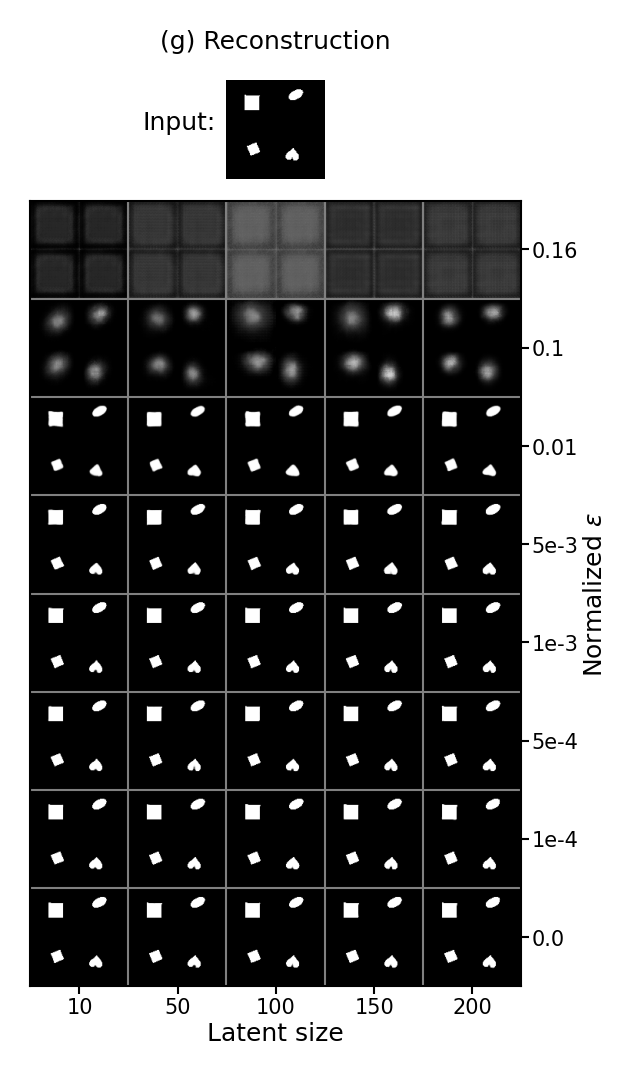

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [1, 8]},
                         dpi=300, facecolor='w') 
plt.subplots_adjust(hspace=0.05)

ax = axes[0]
ax.imshow(img_data.T, origin='lower', cmap='binary_r')
ax.axis('off')
ax.text(-110, 64, 'Input:', fontsize=fontsize)
ax.set_title('(g) Reconstruction', fontsize=fontsize, y=1.2)

ax = axes[1]
ax.imshow(img_big.T, origin='lower', cmap='binary_r')
ax.set_xticks(np.arange(N, len(nlats_img) * N - 1, N) - .5, minor=True)
ax.set_yticks(np.arange(N, len(epses_img) * N - 1, N) - .5, minor=True)
ax.grid(which='minor', c='gray', lw=.5)
ax.set_xticks(np.arange(N / 2, len(nlats_img) * N - 1, N))
ax.set_yticks(np.arange(N / 2, len(epses_img) * N - 1, N))
ax.set_xticklabels(nlats_img, fontsize=fontsize-1)
ax.set_xlabel(r'Latent size', fontsize=fontsize)
ax.set_yticklabels(epses_img, fontsize=fontsize-1)
yl = ax.get_yticklabels()
yl[1] = yl[1].__class__(0, 5, '1e-4')
yl[2] = yl[2].__class__(0, 5, '5e-4')
yl[3] = yl[3].__class__(0, 5, '1e-3')
yl[4] = yl[4].__class__(0, 5, '5e-3')
ax.set_yticklabels(yl)
ax.set_ylabel(r'Normalized $\epsilon$', fontsize=fontsize)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.tick_params('both', length=2, pad=0.5, which='major', labelsize=fontsize-1)
plt.savefig('figures/reconstruction_rec.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

# Metric

In [7]:
# read grid
epses = np.loadtxt(f'grid_eps_{cons}')
nlats = np.loadtxt('grid_nlats').astype(int)

# read data
LCM = np.load(f'results/{cons}/metric_LCM.npy')
MIG = np.load(f'results/{cons}/metric_MIG.npy')
MID = np.load(f'results/{cons}/metric_MID.npy')
REC = np.load(f'results/{cons}/metric_REC.npy')
KL = np.load(f'results/{cons}/metric_KL.npy')
LOSS = np.load(f'results/{cons}/metric_LOSS.npy')
LMBD = np.load(f'results/{cons}/metric_LMBD.npy')

# normalise
REC /= 4096
LOSS /= 4096
KL /= nlats
LMBD *= 4096 / nlats

In [8]:
def plot_metric(fig, ax, data, cm, title, vmin=None, vmax=None, xtick=False, ytick=False, 
                cm_scale=1, fontsize=6):
    im = ax.imshow(data[:, ::-1] * cm_scale, origin='lower', 
                   cmap=cm, vmin=vmin*cm_scale, vmax=vmax*cm_scale)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="6%", pad=0.01)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params('both', length=0, pad=0.5, which='major', labelsize=fontsize/6*5)
    ax.set_xticks(xticks_id)
    ax.set_yticks(yticks_id)
    if xtick:
        ax.set_xticklabels(xticks, fontsize=fontsize/6*5)
        ax.set_xlabel(r'Latent size', fontsize=fontsize)
    else:
        ax.set_xticklabels([])
    if ytick:
        ax.set_yticklabels(yticks, fontsize=fontsize/6*5)
        yl = ax.get_yticklabels()
        yl[1] = yl[1].__class__(0, 5, '1e-4')
        yl[2] = yl[2].__class__(0, 5, '5e-4')
        yl[3] = yl[3].__class__(0, 5, '1e-3')
        yl[4] = yl[4].__class__(0, 5, '5e-3')
        ax.set_yticklabels(yl)
        ax.set_ylabel(r'Normalized $\epsilon$', fontsize=fontsize)
    else:
        ax.set_yticklabels([])
    if cm_scale != 1:
        title += ' (×%d)' % cm_scale
    ax.set_title(title, fontsize=fontsize)
    ax.tick_params('both', length=2, width=0.5, pad=0.5, which='major')
    ax.set_xticks(np.arange(len(nlats) - 1) + .5, minor=True)
    ax.set_yticks(np.arange(len(epses)) + .5, minor=True)
    ax.grid(which='minor', c='gray', lw=.1)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xlim(-.6, 24.6)
    ax.set_ylim(-.6, 31.6)
    ax.plot([-.5, 24.5], [-.5, -.5], c='k', lw=.5)
    ax.plot([24.5, 24.5], [-.5, 31.5], c='k', lw=.5)
    ax.plot([24.5, -0.5], [31.5, 31.5], c='k', lw=.5)
    ax.plot([-.5, -.5], [-.5, 31.5], c='k', lw=.5)

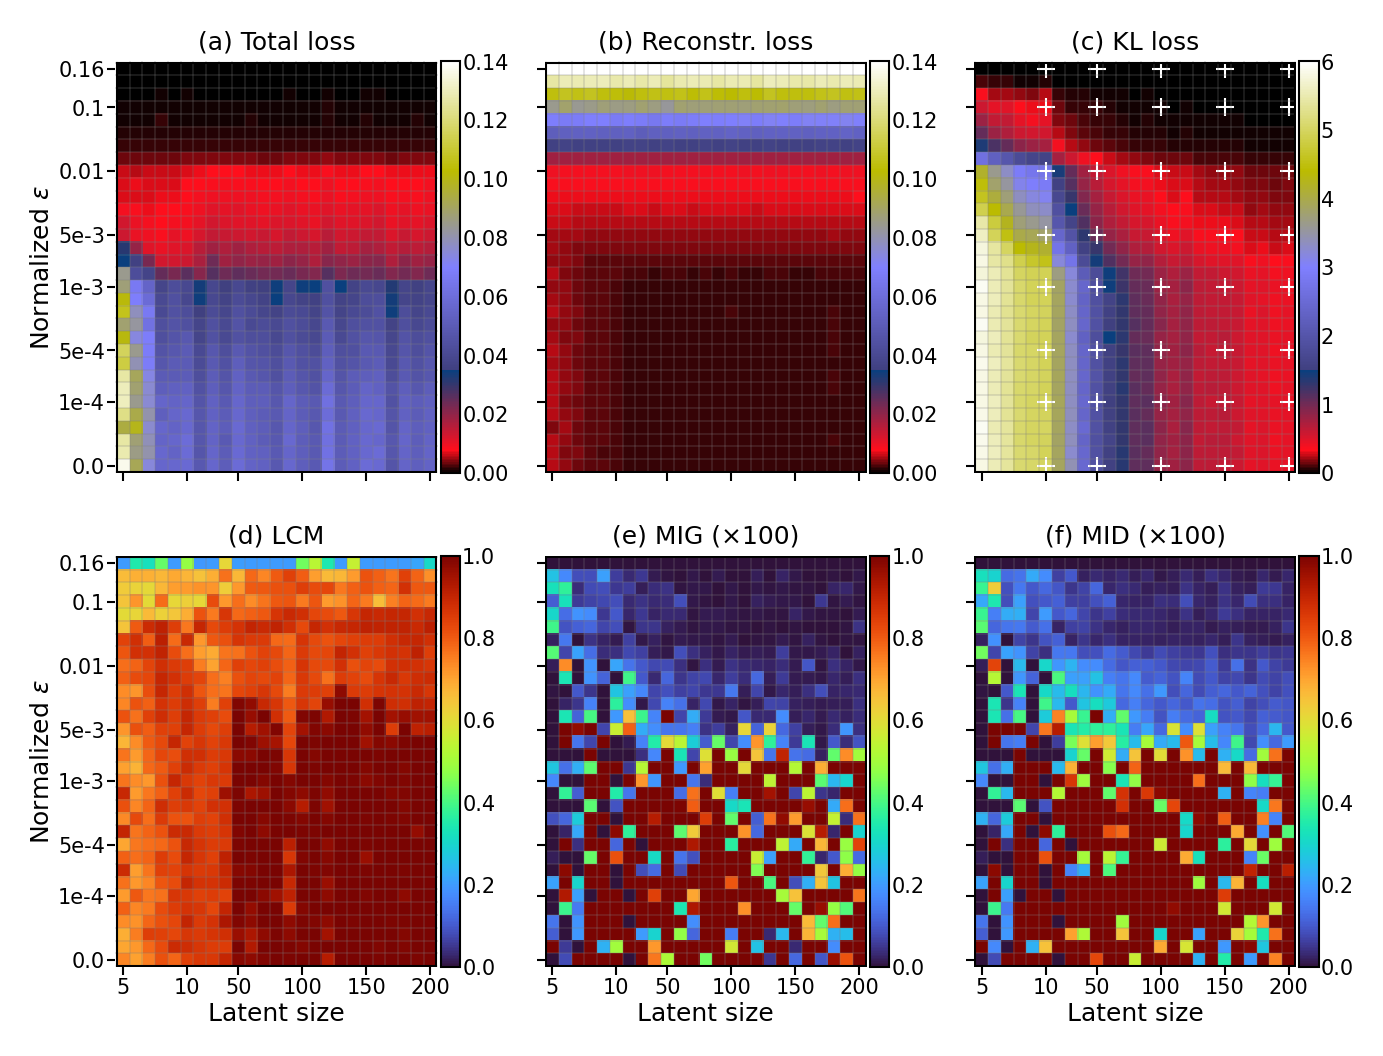

In [9]:
# settings
xticks_id = np.array([0, 5, 9, 14, 19, 24])
yticks_id = [0, 5, 9, 14, 18, 23, 28, 31]
xticks = nlats[::-1][xticks_id]
yticks = epses[yticks_id]
cm_loss = 'gist_stern'
cm_metric = 'turbo'

# metrics
fig, axes = plt.subplots(nrows=2, ncols=3, dpi=300, facecolor='w') 
plt.subplots_adjust(wspace=-.2)
plot_metric(fig, axes[0, 0], LOSS, cm_loss, '(a) Total loss', vmin=0, vmax=0.14, 
            xtick=False, ytick=True)
plot_metric(fig, axes[0, 1], REC, cm_loss, '(b) Reconstr. loss', vmin=0, vmax=0.14, 
            xtick=False, ytick=False)
plot_metric(fig, axes[0, 2], KL, cm_loss, '(c) KL loss', vmin=0., vmax=6., 
            xtick=False, ytick=False)
plot_metric(fig, axes[1, 0], LCM, cm_metric, '(d) LCM', vmin=0, vmax=1.0, 
            xtick=True, ytick=True)
cm_scale = 100
plot_metric(fig, axes[1, 1], MIG, cm_metric, '(e) MIG', vmin=0, vmax=1/cm_scale, 
            xtick=True, ytick=False, cm_scale=cm_scale)
plot_metric(fig, axes[1, 2], MID, cm_metric, '(f) MID', vmin=0, vmax=1/cm_scale, 
            xtick=True, ytick=False, cm_scale=cm_scale)

xticks_id_rec = [5, 9, 14, 19, 24]
yticks_id_rec = []
for eps_img in epses_img:
    yticks_id_rec.append(list(epses).index(eps_img))
x, y = np.meshgrid(xticks_id_rec, yticks_id_rec)
axes[0, 2].scatter(x, y, c='w', marker='+', s=20, lw=0.5)

plt.savefig(f'figures/metrics_{cons}.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

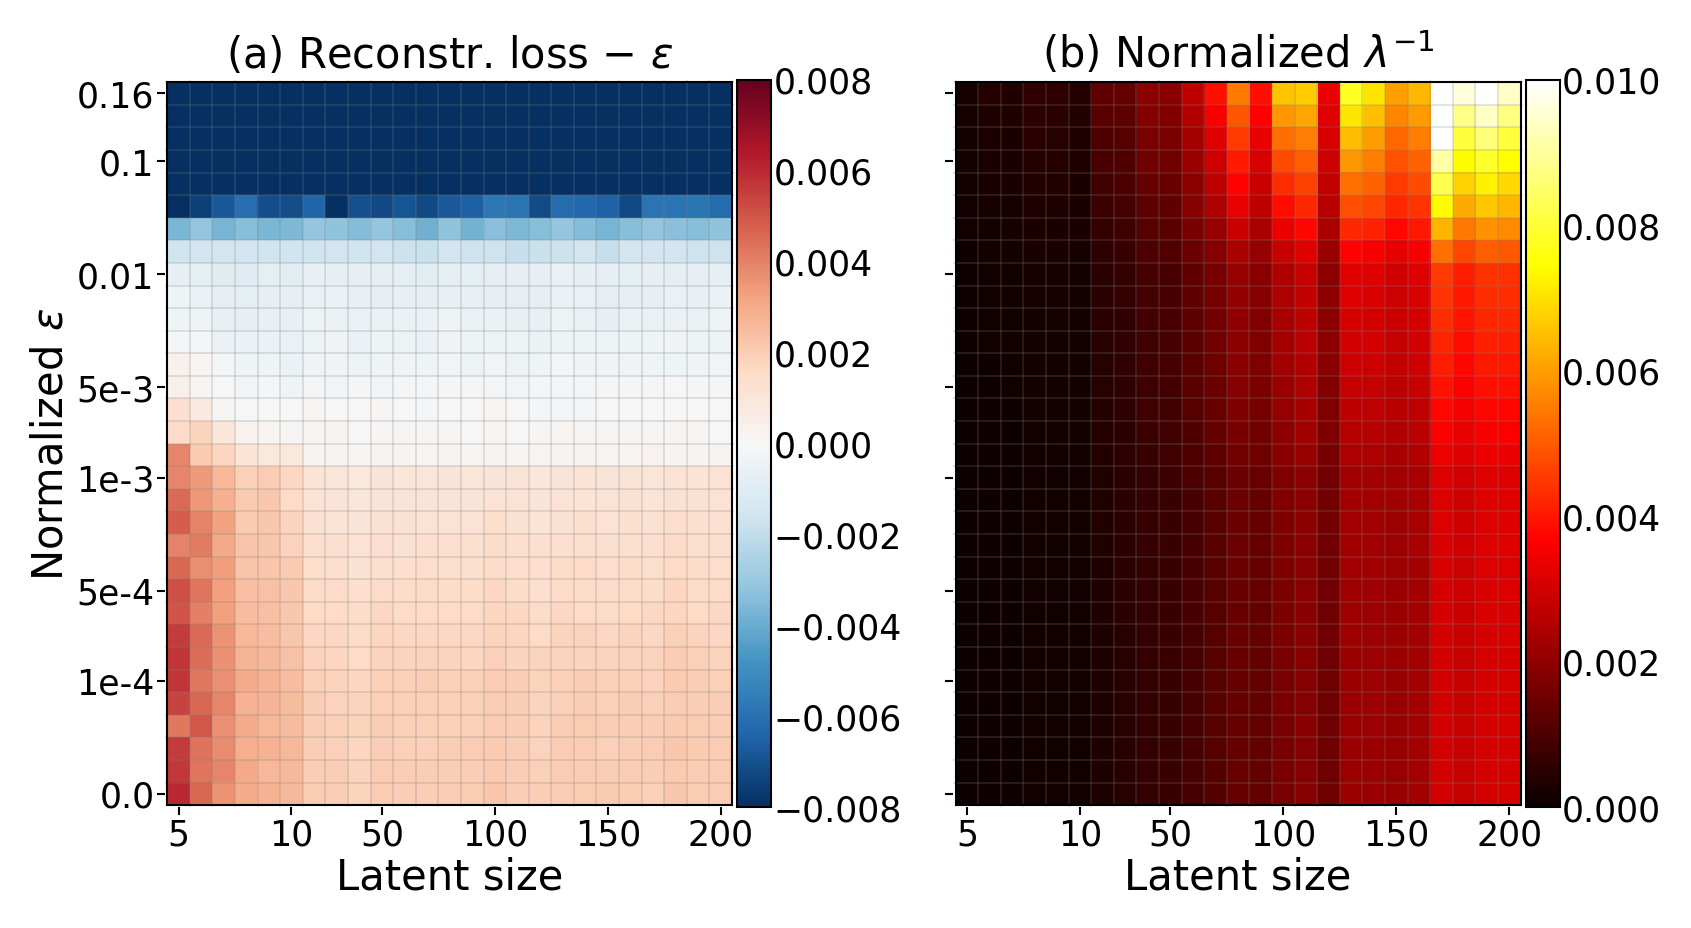

In [20]:
# metrics
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=300, facecolor='w') 
plt.subplots_adjust(wspace=.3)

plot_metric(fig, axes[0], (REC.T - epses).T, 'RdBu_r', 
            r'(a) Reconstr. loss $-\ \epsilon$', vmin=-.008, vmax=.008, 
            xtick=True, ytick=True, fontsize=10)
plot_metric(fig, axes[1], 1 / LMBD, 'hot',
            '(b) Normalized $\lambda^{-1}$', vmin=0, vmax=.01, 
            xtick=True, ytick=False, fontsize=10)

plt.savefig(f'figures/lambda_{cons}.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

# History

In [23]:
def plot_hist(fname):
    hist = np.load(f'results/{cons}/{fname}.npy')
    fig, axes = plt.subplots(nrows=len(yticks_id), ncols=len(xticks_id_rec), dpi=200, facecolor='w')
    for i, lat_id in enumerate(yticks_id):
        for j, eps_id in enumerate(xticks_id_rec):
            axes[i, j].plot(hist[lat_id, eps_id].reshape(-1), c='k', lw=.2)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            axes[i, j].axis('off')
    fig.suptitle(fname, y=.92)
    plt.show()

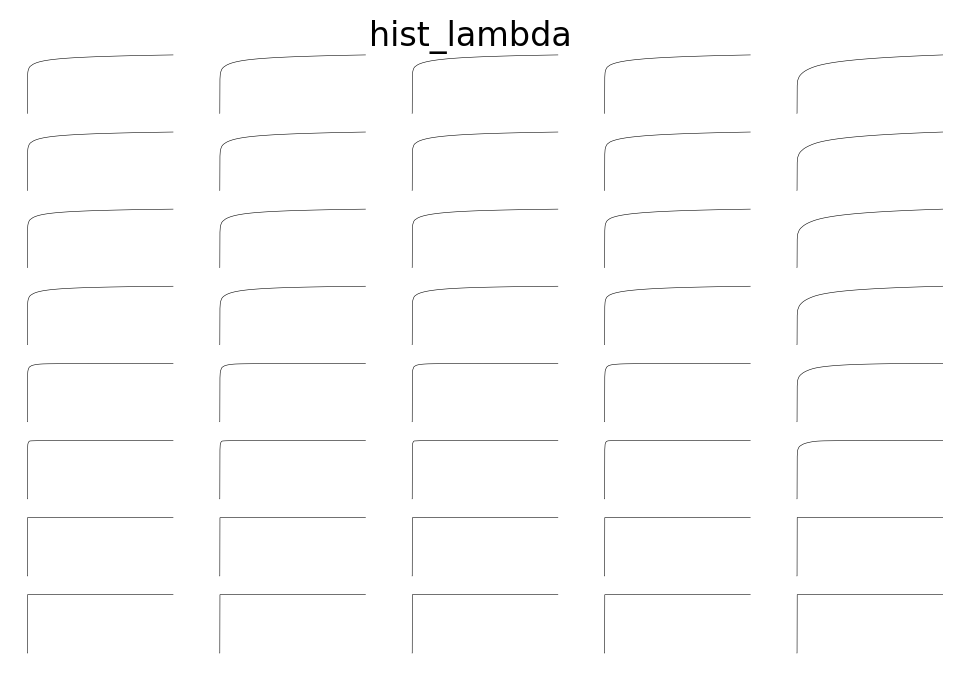

In [24]:
plot_hist('hist_lambda')